In [11]:
###
#This is a code for solving the inviscid Burgers’ equation and its automatic optimizer. 
# We employ DL(The neural network) to solve the PDE problem. While training, 
# we use the Adam optimizer to update parameters and find the smallest error between the exact resolution and the network's output.
###

In [12]:
## import the function we use
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# import the exact resolution
def gen_testdata():
    exact = np.loadtxt('exact solution.txt').reshape(100,128)
    t = np.arange(0,1,0.01)
    x = np.linspace(0, 2*np.pi, 128, endpoint=True)
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

# the equation we calculate
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    return dy_t + y * dy_x

# result visualization
def plot_result(x, y_pred, y_true, i):
    plt.clf()
    plt.plot(x,y_pred,'x')
    plt.plot(x, y_true, 'r-')
    plt.xlim(0, 2.0*np.pi)
    plt.ylim(-1.1, 1.1)
    plt.savefig('out-%04d.png' % i)



Compiling model...
'compile' took 0.000146 s

Training model...

0         [1.32e-01, 2.14e-01, 1.09e+00]    [1.32e-01, 2.14e-01, 1.09e+00]    []  
1000      [1.62e-02, 7.85e-04, 9.18e-03]    [1.62e-02, 7.85e-04, 9.18e-03]    []  
2000      [8.57e-03, 3.26e-04, 5.26e-03]    [8.57e-03, 3.26e-04, 5.26e-03]    []  
3000      [3.03e-03, 7.86e-05, 2.56e-03]    [3.03e-03, 7.86e-05, 2.56e-03]    []  
4000      [1.72e-03, 1.47e-05, 1.33e-03]    [1.72e-03, 1.47e-05, 1.33e-03]    []  
5000      [1.09e-03, 8.30e-06, 7.42e-04]    [1.09e-03, 8.30e-06, 7.42e-04]    []  
6000      [7.88e-04, 5.54e-06, 4.99e-04]    [7.88e-04, 5.54e-06, 4.99e-04]    []  
7000      [5.86e-04, 2.35e-06, 3.77e-04]    [5.86e-04, 2.35e-06, 3.77e-04]    []  
8000      [4.72e-04, 1.19e-06, 3.05e-04]    [4.72e-04, 1.19e-06, 3.05e-04]    []  
9000      [4.02e-04, 5.28e-07, 2.55e-04]    [4.02e-04, 5.28e-07, 2.55e-04]    []  
10000     [3.50e-04, 3.71e-07, 2.17e-04]    [3.50e-04, 3.71e-07, 2.17e-04]    []  
11000     [3.06e-04, 5

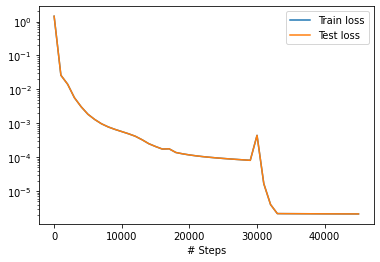

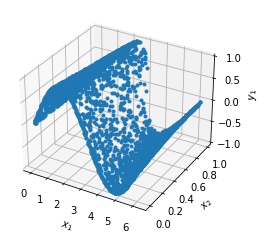

In [13]:
## generate the model and train the parameter
# In this code, you can change the initialize value of 'lr', 'iterations' to get different results. 

geom = dde.geometry.Interval(0, 2*np.pi) # the domain of x
timedomain = dde.geometry.TimeDomain(0, 0.99) # the domain of t
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary) # the boundary condition of the equation
ic = dde.icbc.IC(
    geomtime, lambda x: np.sin(x[:, 0:1]), lambda _, on_initial: on_initial
) # The initial conditions of the equation

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal") # generate the network
model = dde.Model(data, net) # generate the model

model.compile("adam", lr=1e-3) # choice 'Adam' as optimizer
model.opt.param_groups[0]['capturable'] = True
model.train(iterations=30000)
model.compile("L-BFGS")
losshistory, train_state = model.train() # start training
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Mean residual: 0.0018078466
L2 loss: 0.5486907615375358


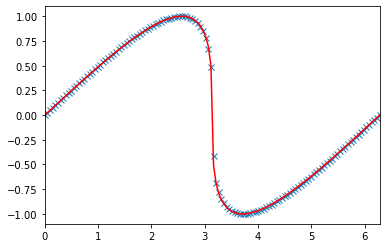

In [14]:
## use the optimized parameters to solve the equation

#calculate the loss of the parameter
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 loss:", np.sqrt(np.sum((y_pred-y_true)**2)))

#visualzation
x = np.linspace(0, 2*np.pi, 128, endpoint=True)
nt = 100
for i in range(nt):
    plot_result(x,y_pred[i*128:(i+1)*128],y_true[i*128:(i+1)*128],i)